In [21]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
from itertools import product
import matplotlib.pyplot as plt
import tsplib95
import time
import scipy.stats

In [2]:
problem = tsplib95.load_problem('cities/a280.tsp')
cities = []
maxCities = 30
for i in range(1, problem.dimension):
    cities.append(problem.get_display(i))

In [3]:
dist = {}

In [4]:
def distance_between_cities(cities, i, j):
    if (i, j) in dist:
        return dist[(i, j)]
    city = cities[i]
    second_city = cities[j]
    dist[(i, j)] = np.sqrt((second_city[0] - city[0])**2 + (second_city[1] - city[1])**2)
    return dist[(i, j)]

In [5]:
def func_distance_with_drone(x, drones, cities, p):
    sum = 0
    tempSumVehicle = 0
    tempSumDrone = 0
    tempIndexCityDrone = 0
    tempIndexCityVehicle = 0
    tempCities = cities.copy()
    tempCities.append(cities[0])
    tempX = np.append(x, 0)
    tempDrones = np.append(drones, 0)
    for i in range(1, len(tempX)):
        if tempDrones[i - 1] == 0 and tempDrones[i] == 0:
            current_distance = distance_between_cities(tempCities, tempX[i-1], tempX[i])
            sum += current_distance
            
            
        if tempDrones[i - 1] == 0 and tempDrones[i] == 1:
            current_distance = distance_between_cities(tempCities, tempX[i-1], tempX[i])
            tempSumDrone += current_distance
            tempIndexCityVehicle = tempX[i-1]
            tempIndexCityDrone = tempX[i]
        
        if tempDrones[i - 1] == 1 and tempDrones[i] == 1:
            current_distance = distance_between_cities(tempCities, tempIndexCityVehicle, tempX[i])
            tempSumVehicle += current_distance
            tempIndexCityVehicle = tempX[i]
        
        if tempDrones[i - 1] == 1 and tempDrones[i] == 0:
            current_distance_vehicle = distance_between_cities(tempCities, tempIndexCityVehicle, tempX[i])
            tempSumVehicle += current_distance_vehicle
            
            current_distance_drone = distance_between_cities(tempCities, tempIndexCityDrone, tempX[i])
            tempSumDrone += current_distance_drone
            
            sum += max(tempSumVehicle, tempSumDrone * p)
            tempSumVehicle = 0
            tempSumDrone = 0
    sum += max(tempSumVehicle, tempSumDrone * p)
    return sum
                
        
    

In [22]:
class GeneticAlgorithm:
    def __init__(self, pop_size = 50, cross_rate=0.25,
                 mutation_rate=0.01, func=None, cities = None, p = 0.5):
        self.func_to_minimize = func
        self.pop_size = pop_size
        self.cross_rate = cross_rate
        self.mutation_rate = mutation_rate
        self.number_of_evaluations = 0
        self.cities = cities
        self.dimension = len(cities)
        self.p = p
    
    def func(self, X, drones, cities, p):
        self.number_of_evaluations += 1
        return 1 / (self.func_to_minimize(X,drones, cities, p))
    
        
    def generatePopulation(self):
        population = []
        for i in range(self.pop_size):
             population.append(self.generateRandom())
        return population
    
    def generatePopulationForDrones(self):
        drones_population = []
        for i in range(self.pop_size):
             drones_population.append(self.generateRandomDrone())
        return drones_population
    
    def generateRandom(self):
        chromosome = np.arange(1, self.dimension)
        np.random.shuffle(chromosome)
        return np.insert(chromosome, 0, 0, axis=0)
    
    def generateRandomDrone(self):
        drones_chromosome = []
        x = 0
        drones_chromosome.append(x)
        for i in range(1, self.dimension):
            if(random.uniform(0, 1) > 0.5):
                x = 1
            else:
                x = 0
            drones_chromosome.append(x)  
        return drones_chromosome
    
    def swap(self, chromosome):
        index1 = np.random.randint(1,self.dimension)
        index2 = np.random.randint(1,self.dimension)
        
        
        temp = chromosome[index1]
        chromosome[index1] = chromosome[index2]
        chromosome[index2] = temp
        return chromosome
    
    def changeBit(self, bite_array, position = None):
        bit_length = len(bite_array)
        index = position
        bite_array = list(bite_array)
        if bite_array[index] == 0:
            bite_array[index] = 1
        else:
            bite_array[index] = 0
        return bite_array
    
    def mutationDrones(self):
        for i in range(len(self.population_drones)):
            for mutation_point in range(1, len(self.cities) - 1):
                if(random.uniform(0, 1) < self.mutation_rate):
                    self.population_drones[i] = self.changeBit(self.population_drones[i], mutation_point)

        
        
    def evaluatePopulation(self):
        return self._evaluatePopulation(self.population, self.population_drones, self.cities, self.p)
    
    def _evaluatePopulation(self, population, population_drones, cities, p):
        evaluatePopulation = []
        for j in range(len(population)):
            chromosome = population[j]
            drone = population_drones[j]
            value = self.func(chromosome, drone, cities, p)
            evaluatePopulation.append(value)
        
        return evaluatePopulation
            
    
    
    def wheel_of_fortune_based_on_rank(self):
        minimum = np.min(self.population_evaluation)
        population_evaluation = self.population_evaluation[:]
        
        indexes = np.argsort(self.population_evaluation[:])
        
        population = np.asarray(self.population)[indexes]
        
        rank_population = np.arange(1, self.pop_size)
        
          
        total_fitness = np.sum(rank_population)
        fitness_per_chromosome = rank_population / total_fitness
        
        
        q = []
        q.append(0.0)
        cumulative_probability = 0
        for fitness in fitness_per_chromosome:
            cumulative_probability += fitness
            q.append(cumulative_probability)
        
        selection = []
        for j in range(self.pop_size):
            fortune =  random.uniform(0, 1)
            for i in range(self.pop_size):
                if q[i] <= fortune and fortune <= q[i+1]:
                    selection.append(population[i][:])
        return selection
    
    
    
    def wheel_of_fortune(self):
        population_evaluation = self.population_evaluation[:]
          
        total_fitness = np.sum(population_evaluation)
        
        fitness_per_chromosome = np.asarray(population_evaluation) / total_fitness
        q = []
        q.append(0.0)
        cumulative_probability = 0
        for fitness in fitness_per_chromosome:
            cumulative_probability += fitness
            q.append(cumulative_probability)
        selection = []
        for j in range(self.pop_size):
            fortune =  random.uniform(0, 1)
            for i in range(self.pop_size):
                if q[i] <= fortune and fortune <= q[i+1]:
                    selection.append(self.population[i][:])
        return selection
    
    
    def cross_over(self):
        indexes_for_cross_over = []
        for i in range(1, len(self.population)):
            if(random.uniform(0, 1) < self.cross_rate):
                indexes_for_cross_over.append(i)
        
        np.random.shuffle(indexes_for_cross_over)
        
        if(len(indexes_for_cross_over) % 2 == 1):
            indexes_for_cross_over.pop()
        
        for i in range(0, len(indexes_for_cross_over), 2):
            idx1 = indexes_for_cross_over[i]
            idx2 = indexes_for_cross_over[i + 1]
            
            parent1 = self.population[idx1]
            parent2 = self.population[idx2]
            child1 = self._cross_over(parent1, parent2)
            child2 = self._cross_over(parent2, parent1)
            
            self.population[idx1] = child1
            self.population[idx2] = child2
            
    def _cross_over(self, parent1, parent2):
        
        start_cross_point = np.random.randint(1, self.dimension)
        end_cross_point = np.random.randint(1, self.dimension)
        child = [None] * self.dimension
        for i in range(len(child)):
            if start_cross_point < end_cross_point and i > start_cross_point and i < end_cross_point:
                child[i] = parent1[i]
            elif start_cross_point > end_cross_point:
                if not (i < start_cross_point and i > end_cross_point):
                    child[i] = parent1[i]

        for i in range(len(parent2)):
            if parent2[i] not in child:
                for j in range(len(child)):
                    if child[j] is None:
                        child[j] = parent2[i]
                        break
        return np.array(child)
            
        
    
    def mutation(self):
        for i in range(len(self.population)):
            if(random.uniform(0, 1) < self.mutation_rate):
                self.population[i] = self.swap(self.population[i])
    
    
    def printBestCurrent(self):
        idx = np.argmax(self.population_evaluation)
        #print("Best current value = " + str(self.func_to_optimize(self.population[idx])))
    
    
    
    def run_genetic_algorithm(self):
        start_time = time.time()
        
        self.population = self.generatePopulation()
        self.population_drones = self.generatePopulationForDrones()
#         print(self.population[0], self.population_drones[1])
        self.population_evaluation = self.evaluatePopulation()
        max = - math.inf
        values = []
        value = None
        x = None
        drone = None
        idx = None
        for i in range(self.number_of_generations):
            if self.selection_type == 'rank':
                self.population = self.wheel_of_fortune()
            else:
                self.population = self.wheel_of_fortune_based_on_rank()
            self.cross_over()
            self.mutation()
            self.mutationDrones()
            self.population_evaluation = self.evaluatePopulation()
            idx = np.argmax(self.population_evaluation)
            if(max < self.population_evaluation[idx]):
                max = self.population_evaluation[idx]
                value = self.func_to_minimize(self.population[idx], self.population_drones[idx],  self.cities, self.p)
                x = self.population[idx]
                drone = self.population_drones[idx]
            values.append(self.func_to_minimize(self.population[idx], self.population_drones[idx],  self.cities, self.p))
        print(time.time() - start_time)
        return values, self.number_of_evaluations, values[-1], x, drone
        
    
    def run(self, number_of_generations = 1, selection_type='fitness'):
        self.number_of_generations = number_of_generations
        self.selection_type = selection_type
        return self.run_genetic_algorithm()

In [23]:
def print_path(cities, x, drones):
    c = np.array(cities)
    a = [cities[x[0]]]
    for i in range(1, len(cities)):
        if not (drones[i-1] == 0 and drones[i] == 1):
            a.append(cities[x[i]])
    a.append(cities[x[0]])
    a = np.array(a)


    b = [cities[x[0]]]
    tempIndex = 0
    for i in range(1, len(drones)):
        if (drones[i-1] + drones[i] == 1):
            b.append(cities[x[i]])

    b.append(cities[x[0]])
    b = np.array(b)


    fig=plt.figure(figsize=(15, 15))
    plt.scatter(c[:, 0] , c[:, 1])

    plt.scatter(c[:, 0] , c[:, 1])

    plt.plot(a[:, 0], a[:, 1])
    plt.plot(b[:, 0], b[:, 1])

    plt.plot(cities[x[0]][0], cities[x[0]][1], 'bo')
    plt.show()
    

In [24]:
cities10 = cities[:10]
cities30 = cities[:30]

cities10_values = []
cities30_values = []
cities_values = []

cities10_path = []
cities30_path = []
cities_path = []

cities10_drones = []
cities30_drones = []
cities_drones = []


In [26]:
model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
                     mutation_rate=0.005, func = func_distance_with_drone, cities = cities, p = 0.5)
values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=10, selection_type='fitness')
# print(last_value, x, drone)

1.839005470275879


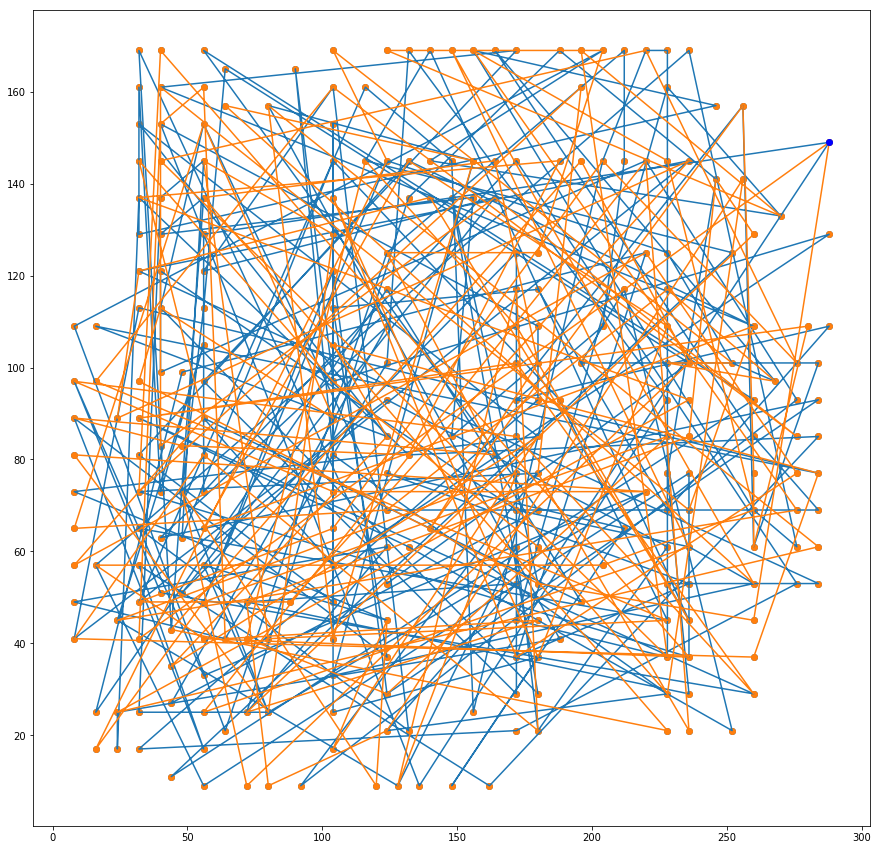

In [27]:
print_path(cities, x, drone)

In [ ]:
cities10 = cities[:10]
cities30 = cities[:30]

cities10_values = []
cities30_values = []
cities_values = []

cities10_path = []
cities30_path = []
cities_path = []

cities10_drones = []
cities30_drones = []
cities_drones = []


nr_of_generations = 5000

# for i in range(10):
#     model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
#                      mutation_rate=0.005, func = func_distance_with_drone, cities = cities10, p = 0.5)
#     values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
#     cities10_values.append(last_value)
#     cities10_path.append(x)
#     cities10_drones.append(drone)

# for i in range(10):
#     model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
#                      mutation_rate=0.005, func = func_distance_with_drone, cities = cities30, p = 0.5)
#     values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
#     cities30_values.append(last_value)
#     cities30_path.append(x)
#     cities30_drones.append(drone)

for i in range(10):
    model = GeneticAlgorithm(pop_size=200, cross_rate=0.005,
                     mutation_rate=0.005, func = func_distance_with_drone, cities = cities, p = 0.5)
    values, number_of_evaluations, last_value, x, drone = model.run(number_of_generations=nr_of_generations, selection_type='fitness')
    print('i=', i)
    cities_values.append(last_value)
    cities_path.append(x)
    cities_drones.append(drone)


753.4550015926361
i= 0
748.6290175914764
i= 1
761.645925283432
i= 2
761.3864326477051
i= 3
762.0544567108154
i= 4
763.1140012741089
i= 5
757.9831788539886
i= 6
759.775972366333
i= 7
765.2349982261658
i= 8


In [46]:
print((sum(cities10_values) / len(cities10_values)))
print((sum(cities30_values) / len(cities30_values)))
print((sum(cities_values) / len(cities_values)))

107.76192819246516
349.4102326146193
663.6549872513003


In [47]:
print((sum(cities10_values) / len(cities10_values)))
print((sum(cities30_values) / len(cities30_values)))
print((sum(cities_values) / len(cities_values)))

107.76192819246516
349.4102326146193
663.6549872513003


30.343200206604255

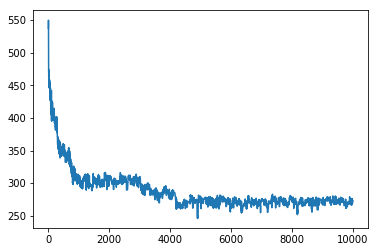

In [44]:
plt.plot(values)
np.std(values)

In [13]:
def print_path(cities, x, drones):
    c = np.array(cities)
    a = [cities[x[0]]]
    for i in range(1, len(cities)):
        if not (drones[i-1] == 0 and drones[i] == 1):
            a.append(cities[x[i]])
    a.append(cities[x[0]])
    a = np.array(a)


    b = [cities[x[0]]]
    tempIndex = 0
    for i in range(1, len(drones)):
        if (drones[i-1] + drones[i] == 1):
            b.append(cities[x[i]])

    b.append(cities[x[0]])
    b = np.array(b)



    plt.scatter(c[:, 0] , c[:, 1])

    plt.scatter(c[:, 0] , c[:, 1])

    plt.plot(a[:, 0], a[:, 1])
    plt.plot(b[:, 0], b[:, 1])

    plt.plot(cities[x[0]][0], cities[x[0]][1], 'bo')
    plt.show()
    

In [20]:
print_path(cities10, cities10_path[3], cities10_drones[3])

IndexError: list index out of range

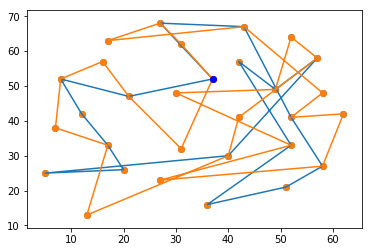

In [48]:
print_path(cities30, cities30_path[0], cities30_drones[0])

In [65]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [74]:
cities10_values
# np.std(cities10_values)
# mean_confidence_interval(cities10_values)

[112.29825521497287,
 101.0861108344656,
 108.30858975574216,
 109.06640537006126,
 114.67252788398476,
 110.71429759095236,
 112.1306309842011,
 96.96002769909924,
 101.00962122129013,
 111.372815369882]

In [67]:
cities30_values
np.mean(cities30_values)

np.std(cities30_values)

mean_confidence_interval(cities30_values)

(349.41023261461925, 340.25394940493686, 358.56651582430163)

In [68]:
cities_values
np.mean(cities_values)

np.std(cities_values)

mean_confidence_interval(cities_values)

(663.6549872513003, 649.383119660138, 677.9268548424626)

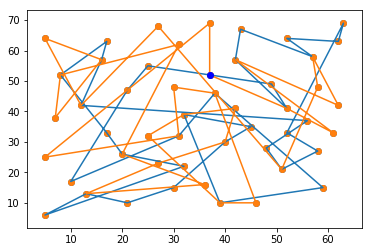

In [80]:
print_path(cities, cities_path[7], cities_drones[7])

In [77]:
cities30_values

[336.36589344233147,
 346.24902424644245,
 345.2413795475236,
 371.1037393862357,
 335.9977027431026,
 350.06659003440154,
 362.6730882976325,
 352.83578832539285,
 361.3547300427043,
 332.2143900804254]